# Importe ausführen und direkt runter zu den 2020 Daten!!!!!!!!!!!!!!!!

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

import wordcloud
import spacy
import nltk

from scipy import stats

C:\Users\mikai\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# Daten Einlesen und ersten Überblick

In [2]:
df = pd.read_parquet("data/steam_reviews.parquet")

In [3]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 9635437 entries, 3 to 21747369
Data columns (total 22 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   app_id                          int64  
 1   app_name                        object 
 2   review_id                       int64  
 3   language                        object 
 4   review                          object 
 5   timestamp_created               int64  
 6   timestamp_updated               int64  
 7   recommended                     bool   
 8   votes_helpful                   int64  
 9   votes_funny                     int64  
 10  weighted_vote_score             float64
 11  comment_count                   int64  
 12  steam_purchase                  bool   
 13  received_for_free               bool   
 14  written_during_early_access     bool   
 15  author.steamid                  int64  
 16  author.num_games_owned          int64  
 17  author.num_reviews             

In [4]:
print(df.head(5))

    app_id                  app_name  review_id language  \
3   292030  The Witcher 3: Wild Hunt   85184605  english   
5   292030  The Witcher 3: Wild Hunt   85184171  english   
6   292030  The Witcher 3: Wild Hunt   85184064  english   
18  292030  The Witcher 3: Wild Hunt   85180436  english   
20  292030  The Witcher 3: Wild Hunt   85179753  english   

                                               review  timestamp_created  \
3   One of the best RPG's of all time, worthy of a...         1611379970   
5              good story, good graphics. lots to do.         1611379264   
6                                            dis gud,         1611379091   
18  favorite game of all time cant wait for the Ne...         1611373086   
20                          Why wouldn't you get this         1611371978   

    timestamp_updated  recommended  votes_helpful  votes_funny  ...  \
3          1611379970         True              0            0  ...   
5          1611379264         True      

In [5]:
# Datentypen Konvertieren
df['app_id'] = df['app_id'].astype('int32')
df['review_id'] = df['review_id'].astype('int32')
df['votes_helpful'] = df['votes_helpful'].astype('int32')
df['votes_funny'] = df['votes_funny'].astype('int32')
df['comment_count'] = df['comment_count'].astype('int32')
df['author.steamid'] = df['author.steamid'].astype('int32')
df['author.num_games_owned'] = df['author.num_games_owned'].astype('int32')
df['author.num_reviews'] = df['author.num_reviews'].astype('int32')

df['author.playtime_forever'] = df['author.playtime_forever'].astype('float32')
df['author.playtime_last_two_weeks'] = df['author.playtime_last_two_weeks'].astype('float32')
df['author.playtime_at_review'] = df['author.playtime_at_review'].astype('float32')

In [6]:
# Zeit konvertieren
df['timestamp_created'] = pd.to_datetime(df['timestamp_created'], unit='s')
df['timestamp_updated'] = pd.to_datetime(df['timestamp_updated'], unit='s')

In [7]:
# Fehlende Werte und Duplikate
print(df.isnull().sum())

app_id                                0
app_name                              0
review_id                             0
language                              0
review                            16754
timestamp_created                     0
timestamp_updated                     0
recommended                           0
votes_helpful                         0
votes_funny                           0
weighted_vote_score                   0
comment_count                         0
steam_purchase                        0
received_for_free                     0
written_during_early_access           0
author.steamid                        0
author.num_games_owned                0
author.num_reviews                    0
author.playtime_forever               2
author.playtime_last_two_weeks        2
author.playtime_at_review         11847
author.last_played                    2
dtype: int64


In [8]:
#entferne duplikate und danach alles wo die review fehlt
df.drop_duplicates(subset='review_id',inplace=True)
df = df.dropna(subset=['review'])

# EDA

Wir werden uns nun die Daten für alle Jahre anschauen und dann später für die Modellierung zuerst die Daten nur für 2020 in betracht ziehen. Falls es mit den 2020 funktioniert, wird es dann für die ganzen Daten implementiert.

## Alle Jahre Numerische Datenanalyse

In [9]:
# Definiere manuelle Grenzwerte für die Bereinigung der Daten
realistic_limits = {
    'votes_helpful': 100,
    'votes_funny': 100,
    'author.playtime_forever': 10000,
    'author.playtime_last_two_weeks': 336
}

# Filtere die Daten basierend auf den festgelegten Grenzwerten
df = df[(df['votes_helpful'] <= realistic_limits['votes_helpful']) &
                (df['votes_funny'] <= realistic_limits['votes_funny']) &
                (df['author.playtime_forever'] <= realistic_limits['author.playtime_forever']) &
                (df['author.playtime_last_two_weeks'] <= realistic_limits['author.playtime_last_two_weeks'])]



In [10]:
stats_summary = df[["votes_helpful","votes_funny","author.playtime_forever","author.playtime_last_two_weeks"]].describe()
print(stats_summary)

       votes_helpful   votes_funny  author.playtime_forever  \
count   6.205648e+06  6.205648e+06             6.205648e+06   
mean    9.266085e-01  2.707266e-01             2.831326e+03   
std     4.171935e+00  2.066008e+00             2.592552e+03   
min     0.000000e+00 -6.000000e+00             0.000000e+00   
25%     0.000000e+00  0.000000e+00             7.490000e+02   
50%     0.000000e+00  0.000000e+00             1.933000e+03   
75%     1.000000e+00  0.000000e+00             4.329000e+03   
max     1.000000e+02  1.000000e+02             1.000000e+04   

       author.playtime_last_two_weeks  
count                    6.205648e+06  
mean                     8.599778e+00  
std                      3.808997e+01  
min                      0.000000e+00  
25%                      0.000000e+00  
50%                      0.000000e+00  
75%                      0.000000e+00  
max                      3.360000e+02  


In [11]:
# Negative votes funny geht nicht?
df = df[df['votes_funny'] >= 0]

In [ ]:
# Plot 1: Verteilung der votes_helpful (0 to 100 with more focus on 0-1 range)
fig1 = px.histogram(df, x='votes_helpful', nbins=200, range_x=(0, 100), title='Verteilung der Helpful Votes (mit Fokus auf 0-1 Bereich)')
fig1.update_xaxes(range=[0, 2])
fig1.show()

# Plot 2: Verteilung der votes_funny (0 to 100 with more focus on 0-1 range)
fig2 = px.histogram(df, x='votes_funny', nbins=200, range_x=(0, 100), title='Verteilung der Funny Votes (mit Fokus auf 0-1 Bereich)')
fig2.update_xaxes(range=[0, 2])
fig2.show()

# Plot 3: Verteilung der Spielzeit (forever) mit Fokus auf 0-10.000, aber Hauptbereich zwischen 0 und 5.000
fig3 = px.histogram(df, x='author.playtime_forever', nbins=200, range_x=(0, 10000), title='Verteilung der gesamten Spielzeit (forever)')
fig3.update_xaxes(range=[0, 5000])
fig3.show()

# Plot 4: Verteilung der Spielzeit (last two weeks) mit Fokus auf 0-336
fig4 = px.histogram(df, x='author.playtime_last_two_weeks', nbins=50, range_x=(0, 336), title='Verteilung der Spielzeit in den letzten zwei Wochen')
fig4.update_xaxes(range=[0, 100])
fig4.show()


In [12]:
df['year'] = df['timestamp_created'].dt.year

In [13]:
df["year"]

21          2021
22          2021
24          2021
40          2021
45          2021
            ... 
21747364    2020
21747366    2020
21747367    2020
21747368    2020
21747369    2020
Name: year, Length: 6205471, dtype: int32

In [ ]:
# Plot 1: Durchschnittliche Helpful Votes über die Jahre
yearly_data = df[['year', 'votes_helpful', 'votes_funny', 'author.playtime_forever', 'author.playtime_last_two_weeks']].groupby('year').mean().reset_index()

fig1 = px.line(yearly_data, x='year', y='votes_helpful', title='Durchschnittliche Helpful Votes über die Jahre')
fig1.show()

# Plot 2: Durchschnittliche Funny Votes über die Jahre
fig2 = px.line(yearly_data, x='year', y='votes_funny', title='Durchschnittliche Funny Votes über die Jahre')
fig2.show()

# Plot 3: Durchschnittliche Spielzeit (forever) über die Jahre
fig3 = px.line(yearly_data, x='year', y='author.playtime_forever', title='Durchschnittliche Spielzeit (forever) über die Jahre')
fig3.show()

# Plot 4: Durchschnittliche Spielzeit (last two weeks) über die Jahre
fig4 = px.line(yearly_data, x='year', y='author.playtime_last_two_weeks', title='Durchschnittliche Spielzeit in den letzten zwei Wochen über die Jahre')
fig4.show()

In [ ]:
# Zähle die Anzahl der Bewertungen pro Jahr
yearly_review_counts = df['year'].value_counts().reset_index()
yearly_review_counts.columns = ['year', 'review_count']
yearly_review_counts = yearly_review_counts.sort_values('year')

# Erstelle ein Balkendiagramm mit den Jahresdaten
fig = px.bar(yearly_review_counts, x='year', y='review_count', title='Anzahl der Bewertungen pro Jahr')
fig.show()

## Daten für Textanalyse: 2020

### EDA

In [14]:
df_2020 = df[df['year'] == 2020]

# Lösche den ursprünglichen DataFrame, um Speicher freizugeben
del df

# Optionale Speicherkontrolle
import gc
gc.collect()

# Überprüfe die Daten von 2020
print(df_2020.info())
#speichere die 2020 daten als parquet ab
df_2020.to_parquet("data/steam_reviews_2020.parquet")

<class 'pandas.core.frame.DataFrame'>
Index: 2396752 entries, 9507 to 21747369
Data columns (total 23 columns):
 #   Column                          Dtype         
---  ------                          -----         
 0   app_id                          int32         
 1   app_name                        object        
 2   review_id                       int32         
 3   language                        object        
 4   review                          object        
 5   timestamp_created               datetime64[ns]
 6   timestamp_updated               datetime64[ns]
 7   recommended                     bool          
 8   votes_helpful                   int32         
 9   votes_funny                     int32         
 10  weighted_vote_score             float64       
 11  comment_count                   int32         
 12  steam_purchase                  bool          
 13  received_for_free               bool          
 14  written_during_early_access     bool          
 15 

# HIER GEHTS WEITER!!!!!!!!!!!!!!!!!!!!!!!

In [15]:
#lese die 2020 parquet daten ein
df_2020 = pd.read_parquet("data/steam_reviews_2020.parquet")

## API Infos
Wir holen uns paar mehr infos aus der API.

In [17]:
#import requests
#import pandas as pd
#import pyarrow.parquet as pq
#
## Beispiel für den DataFrame mit den Spiel-IDs
#app_ids = df_2020['app_id'].unique()
#
## Definiere die Funktion, um die API zu nutzen und die Daten zu extrahieren
#def get_game_info(app_id):
#    url = f"https://store.steampowered.com/api/appdetails?appids={app_id}&l=english"
#    response = requests.get(url)
#    
#    if response.status_code == 200:
#        data = response.json().get(str(app_id), {}).get('data', {})
#        if data:
#            publisher = data.get('publishers', [None])[0]  # Publisher
#            genres = [genre['description'] for genre in data.get('genres', [])]  # Genre(s)
#            notes = data.get('content_descriptors', {}).get('notes', None)  # Notes
#            return {'app_id': app_id, 'publisher': publisher, 'genres': genres, 'notes': notes}
#    return {'app_id': app_id, 'publisher': None, 'genres': None, 'notes': None}
#
## Erstelle eine Liste, um die Daten zu speichern
#game_info_list = []
#
## Iteriere über die Spiel-IDs und hole die Daten von der API
#for app_id in app_ids:
#    game_info = get_game_info(app_id)
#    game_info_list.append(game_info)
#
## Konvertiere die Ergebnisse in einen DataFrame
#df_game_info = pd.DataFrame(game_info_list)
#
## Speichere die Daten im Parquet-Format
#df_game_info.to_parquet('game_info.parquet', engine='pyarrow')
#
#print("Daten erfolgreich in 'game_info.parquet' gespeichert.")
#

Daten erfolgreich in 'game_info.parquet' gespeichert.


In [19]:
df_game_info = pd.read_parquet('game_info.parquet')

In [21]:
df_game_info

,app_id,publisher,genres,notes
0,292030,CD PROJEKT RED,[RPG],The Witcher 3: Wild Hunt contains strong langu...
1,70,Valve,[Action],None
2,240,Valve,[Action],Includes intense violence and blood.
3,420,Valve,[Action],None
4,620,Valve,"[Action, Adventure]",None
...,...,...,...,...
309,530070,Dovetail Games - TSW,[Simulation],None
310,574050,Square Enix,"[Action, RPG]",None
311,572410,Paradox Interactive,"[Action, Simulation, Strategy]",None
312,421020,Codemasters,"[Racing, Simulation, Sports]",None


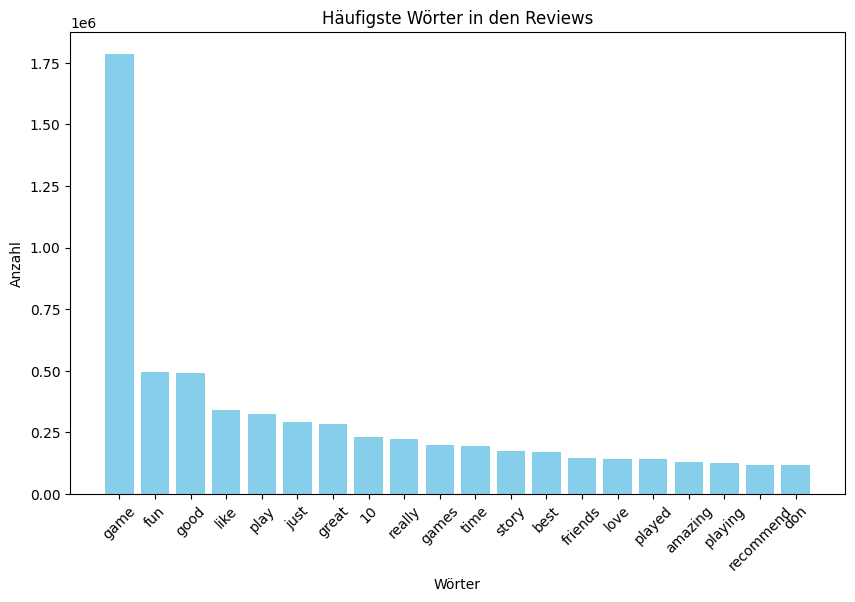

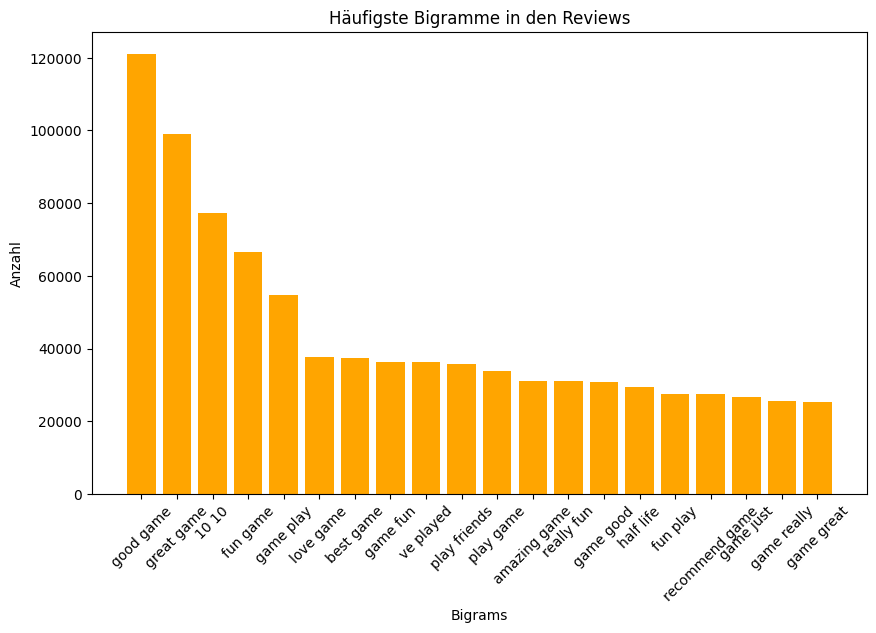

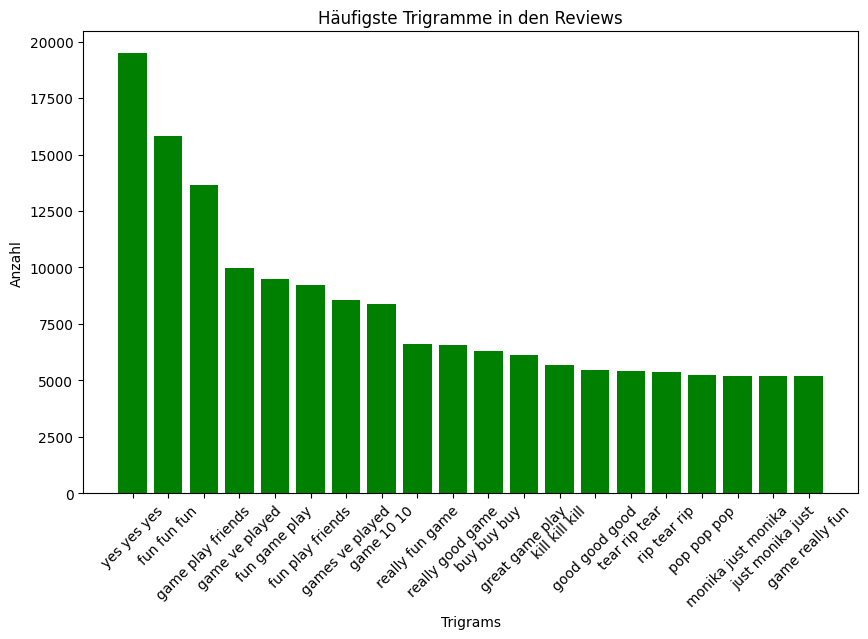

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter

# Beispiel-Reviews (in deinem Fall wird df_2020['review'] verwendet)
reviews = df_2020['review'].astype(str).tolist()

# Vektorisiere die Texte, um die häufigsten Wörter zu extrahieren
vectorizer = CountVectorizer(stop_words='english', max_features=20)
X = vectorizer.fit_transform(reviews)
word_counts = X.toarray().sum(axis=0)

# Erstelle einen DataFrame für die häufigsten Wörter
words_df = pd.DataFrame({'word': vectorizer.get_feature_names_out(), 'count': word_counts})
words_df = words_df.sort_values(by='count', ascending=False)

# Plot: Häufigste Wörter
plt.figure(figsize=(10, 6))
plt.bar(words_df['word'], words_df['count'], color='skyblue')
plt.title('Häufigste Wörter in den Reviews')
plt.xticks(rotation=45)
plt.xlabel('Wörter')
plt.ylabel('Anzahl')
plt.show()

# Bigramm-Analyse
vectorizer_bigram = CountVectorizer(ngram_range=(2, 2), stop_words='english', max_features=20)
X_bigram = vectorizer_bigram.fit_transform(reviews)
bigram_counts = X_bigram.toarray().sum(axis=0)

# Erstelle einen DataFrame für die häufigsten Bigramme
bigrams_df = pd.DataFrame({'bigram': vectorizer_bigram.get_feature_names_out(), 'count': bigram_counts})
bigrams_df = bigrams_df.sort_values(by='count', ascending=False)

# Plot: Häufigste Bigramme
plt.figure(figsize=(10, 6))
plt.bar(bigrams_df['bigram'], bigrams_df['count'], color='orange')
plt.title('Häufigste Bigramme in den Reviews')
plt.xticks(rotation=45)
plt.xlabel('Bigrams')
plt.ylabel('Anzahl')
plt.show()

# Trigramm-Analyse
vectorizer_trigram = CountVectorizer(ngram_range=(3, 3), stop_words='english', max_features=20)
X_trigram = vectorizer_trigram.fit_transform(reviews)
trigram_counts = X_trigram.toarray().sum(axis=0)

# Erstelle einen DataFrame für die häufigsten Trigramme
trigrams_df = pd.DataFrame({'trigram': vectorizer_trigram.get_feature_names_out(), 'count': trigram_counts})
trigrams_df = trigrams_df.sort_values(by='count', ascending=False)

# Plot: Häufigste Trigramme
plt.figure(figsize=(10, 6))
plt.bar(trigrams_df['trigram'], trigrams_df['count'], color='green')
plt.title('Häufigste Trigramme in den Reviews')
plt.xticks(rotation=45)
plt.xlabel('Trigrams')
plt.ylabel('Anzahl')
plt.show()


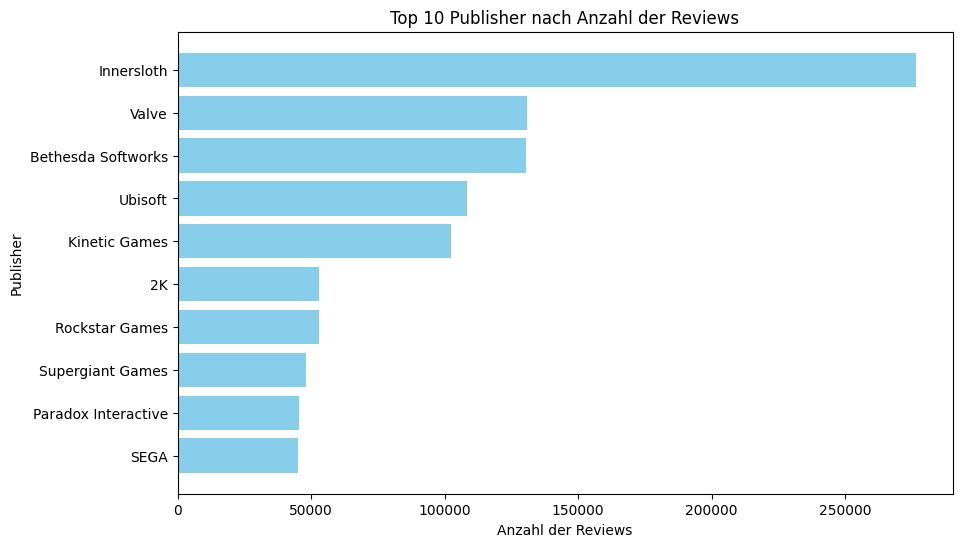

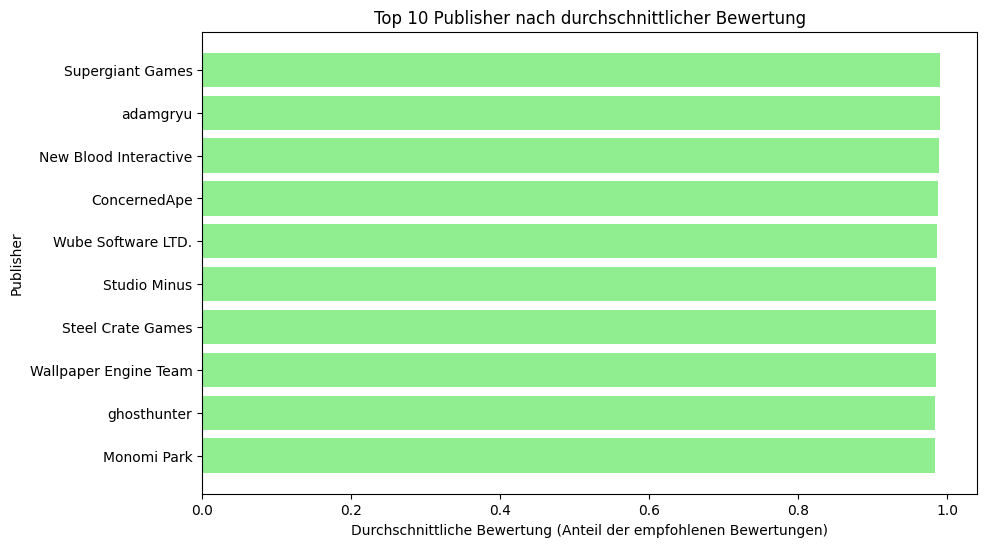

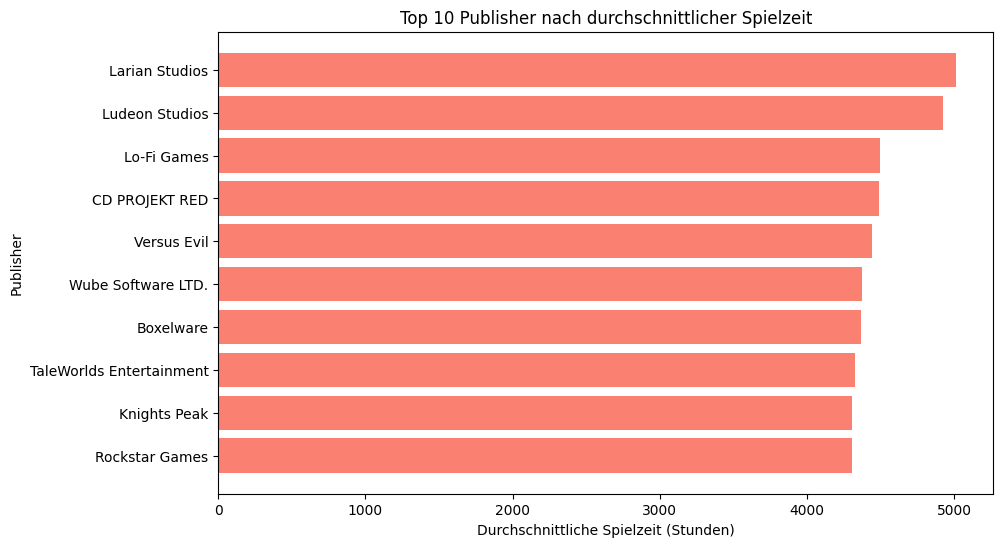

In [29]:
df_merged = pd.merge(df_2020, df_game_info, on='app_id', how='left')
import matplotlib.pyplot as plt

# 1. Anzahl der Reviews pro Publisher
publisher_reviews = df_merged.groupby('publisher').size().reset_index(name='review_count')
top_publishers = publisher_reviews.sort_values(by='review_count', ascending=False).head(10)

# Plot: Publisher mit den meisten Reviews
plt.figure(figsize=(10, 6))
plt.barh(top_publishers['publisher'], top_publishers['review_count'], color='skyblue')
plt.title('Top 10 Publisher nach Anzahl der Reviews')
plt.xlabel('Anzahl der Reviews')
plt.ylabel('Publisher')
plt.gca().invert_yaxis()  # Umkehrung der Achse für bessere Lesbarkeit
plt.show()

# 2. Durchschnittliche Bewertung pro Publisher
publisher_ratings = df_merged.groupby('publisher')['recommended'].agg(['sum', 'count']).reset_index()
publisher_ratings['avg_rating'] = publisher_ratings['sum'] / publisher_ratings['count']  # Berechnung der durchschnittlichen Bewertung

# Sortiere nach der durchschnittlichen Bewertung und zeige die Top 10
top_publisher_ratings = publisher_ratings.sort_values(by='avg_rating', ascending=False).head(10)

# Plot: Durchschnittliche Bewertung pro Publisher
plt.figure(figsize=(10, 6))
plt.barh(top_publisher_ratings['publisher'], top_publisher_ratings['avg_rating'], color='lightgreen')
plt.title('Top 10 Publisher nach durchschnittlicher Bewertung')
plt.xlabel('Durchschnittliche Bewertung (Anteil der empfohlenen Bewertungen)')
plt.ylabel('Publisher')
plt.gca().invert_yaxis()
plt.show()

# 3. Durchschnittliche Spielzeit pro Publisher
publisher_playtime = df_merged.groupby('publisher')['author.playtime_forever'].mean().reset_index(name='avg_playtime')
top_publisher_playtime = publisher_playtime.sort_values(by='avg_playtime', ascending=False).head(10)

# Plot: Durchschnittliche Spielzeit pro Publisher
plt.figure(figsize=(10, 6))
plt.barh(top_publisher_playtime['publisher'], top_publisher_playtime['avg_playtime'], color='salmon')
plt.title('Top 10 Publisher nach durchschnittlicher Spielzeit')
plt.xlabel('Durchschnittliche Spielzeit (Stunden)')
plt.ylabel('Publisher')
plt.gca().invert_yaxis()
plt.show()


n-Gramme für das Spiel: Among Us


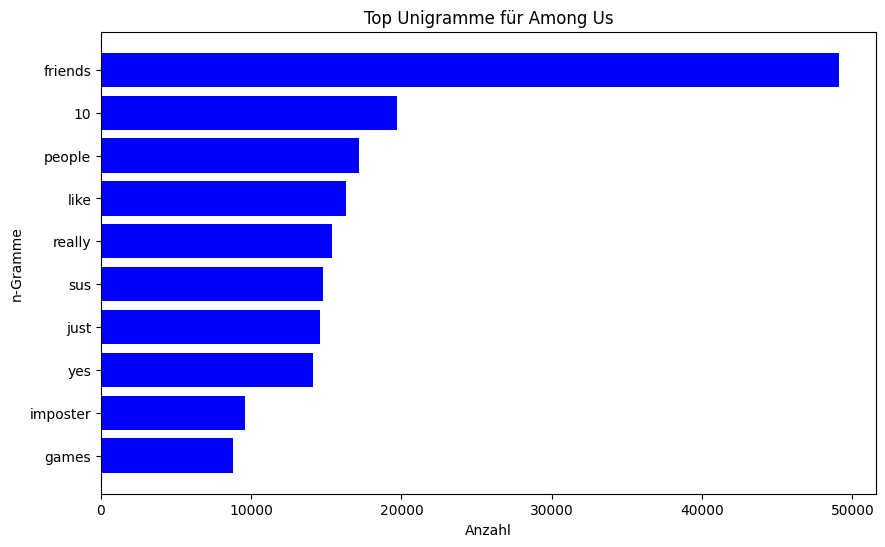

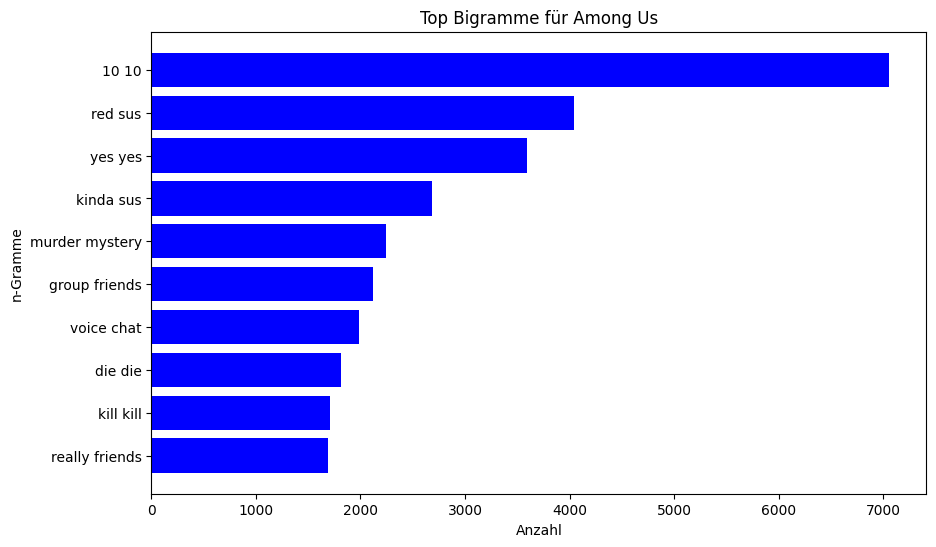

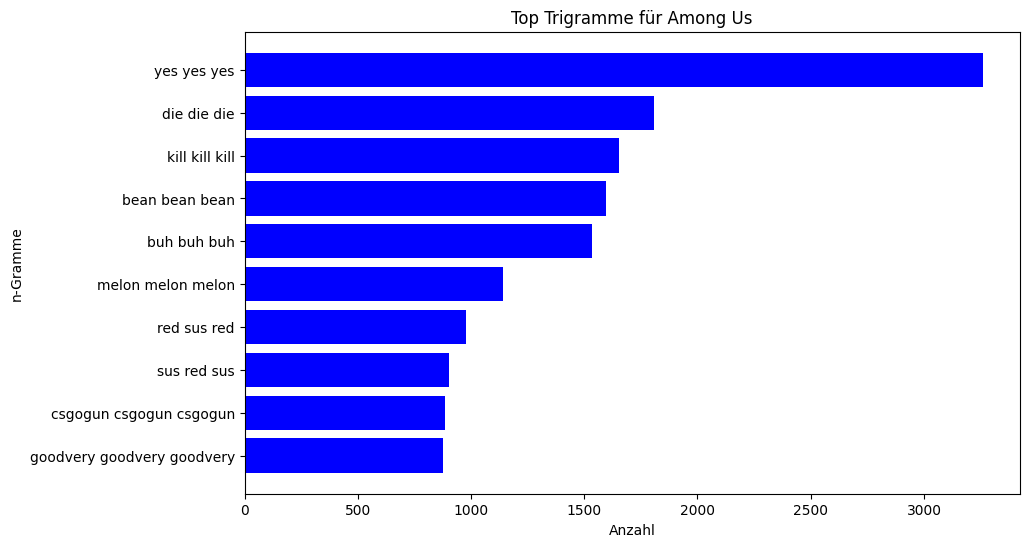

n-Gramme für das Spiel: Phasmophobia


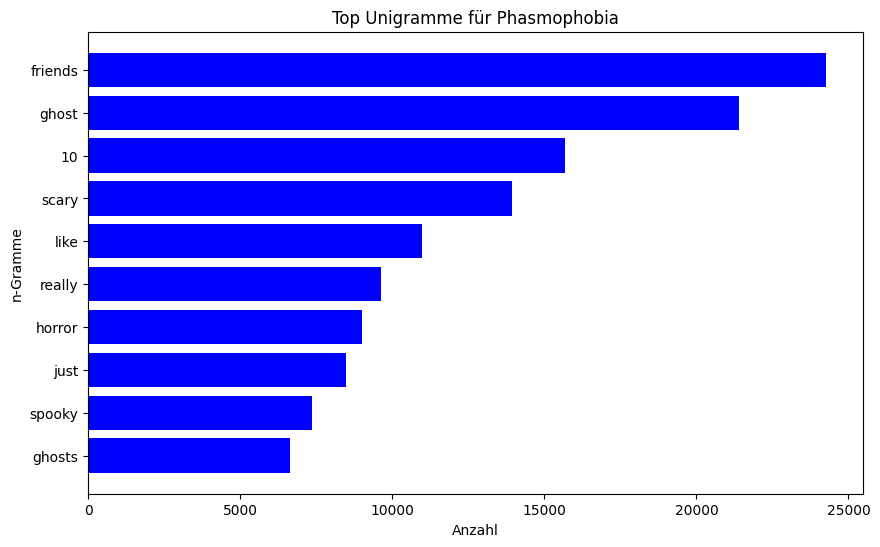

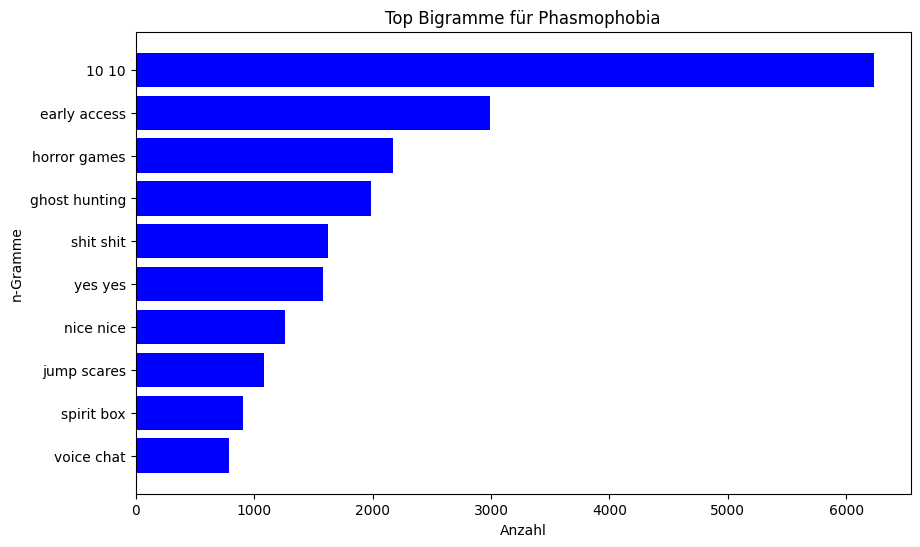

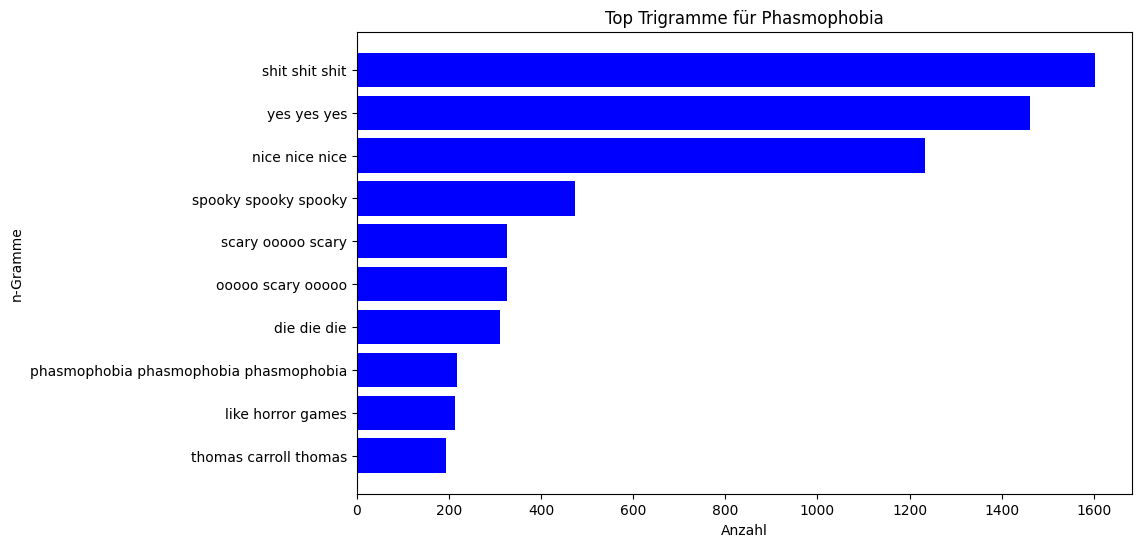

n-Gramme für das Spiel: Terraria


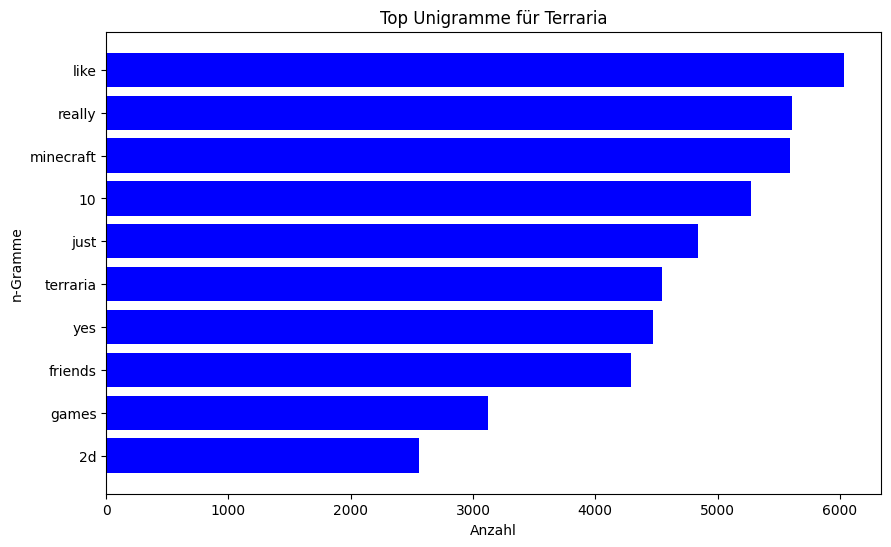

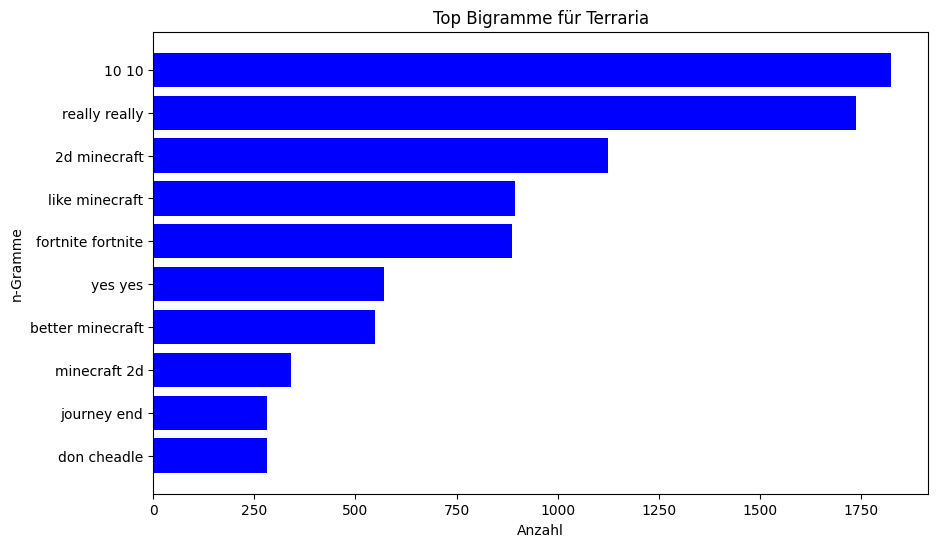

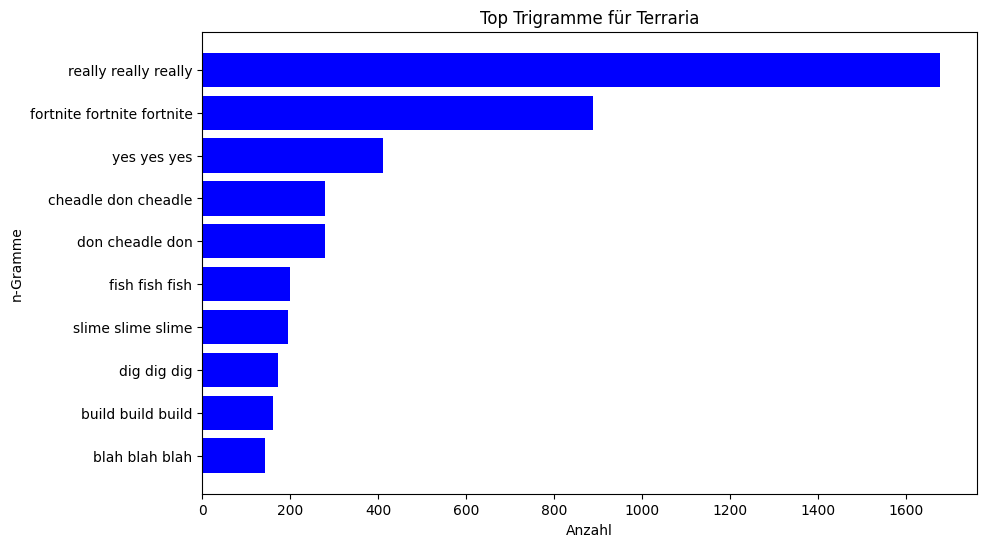

n-Gramme für das Spiel: DOOM Eternal


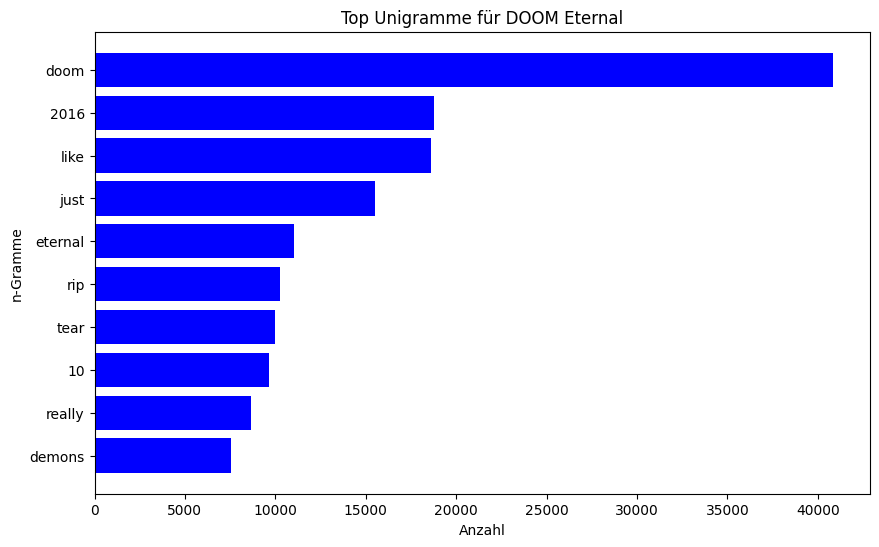

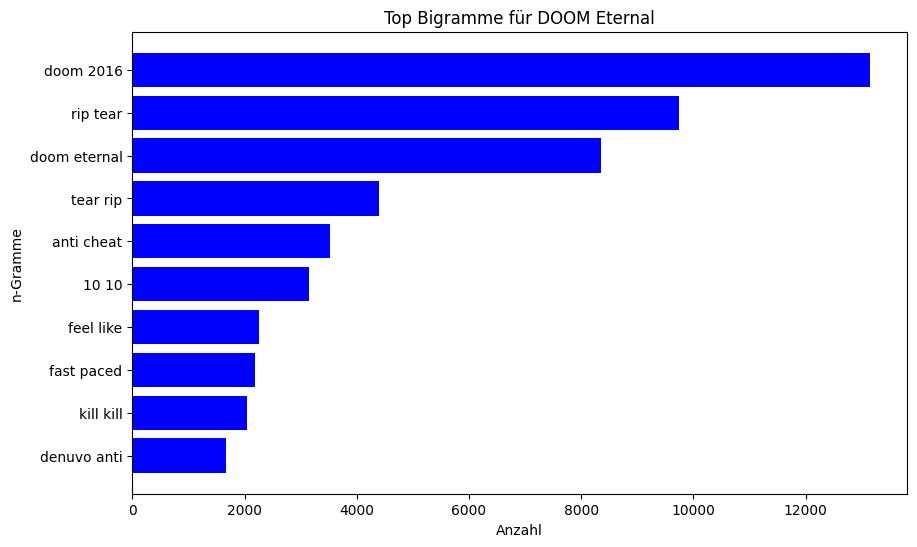

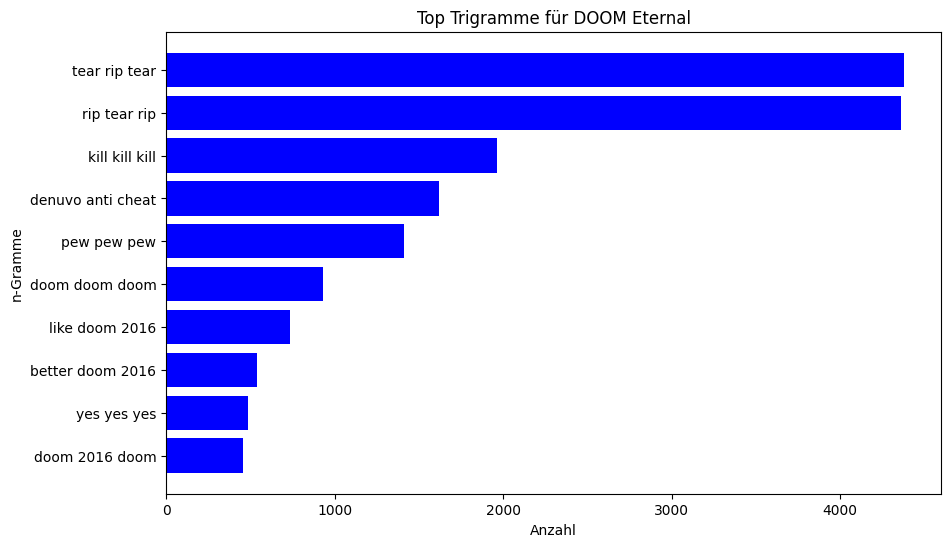

n-Gramme für das Spiel: Tom Clancy's Rainbow Six Siege


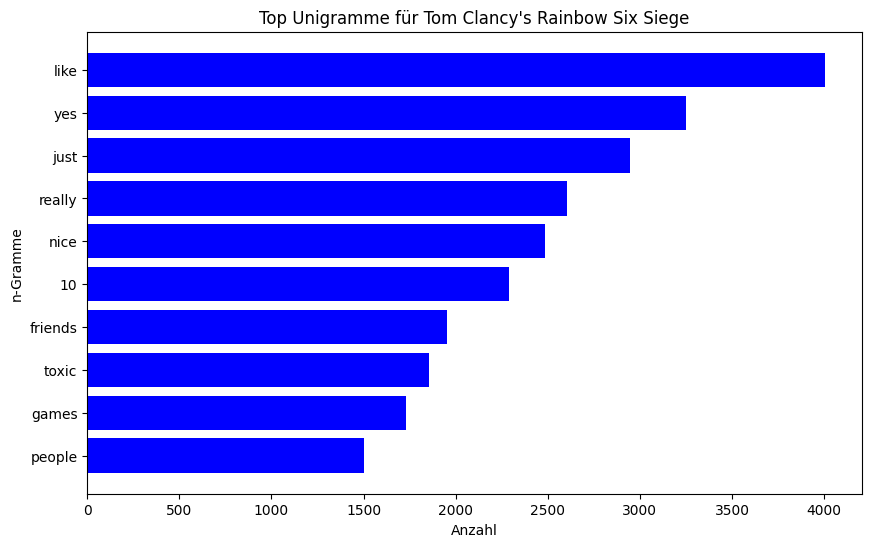

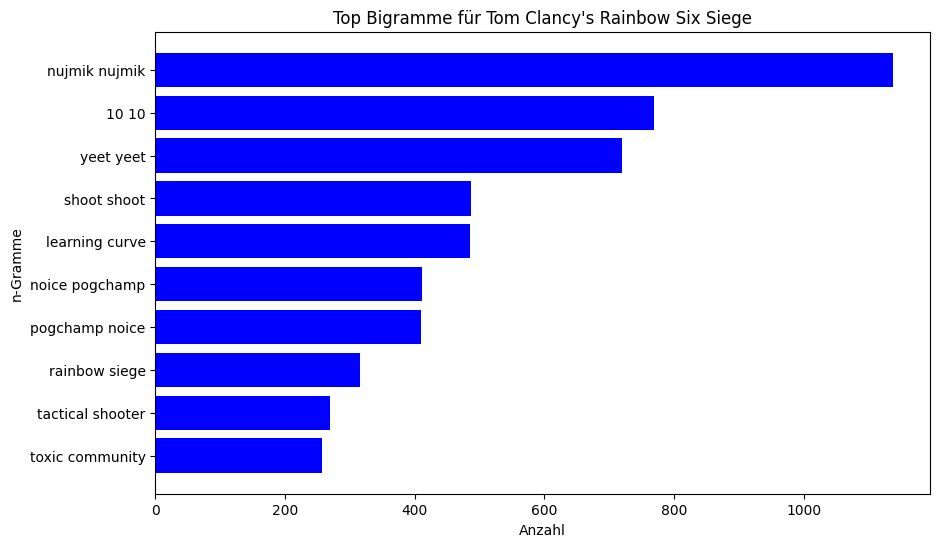

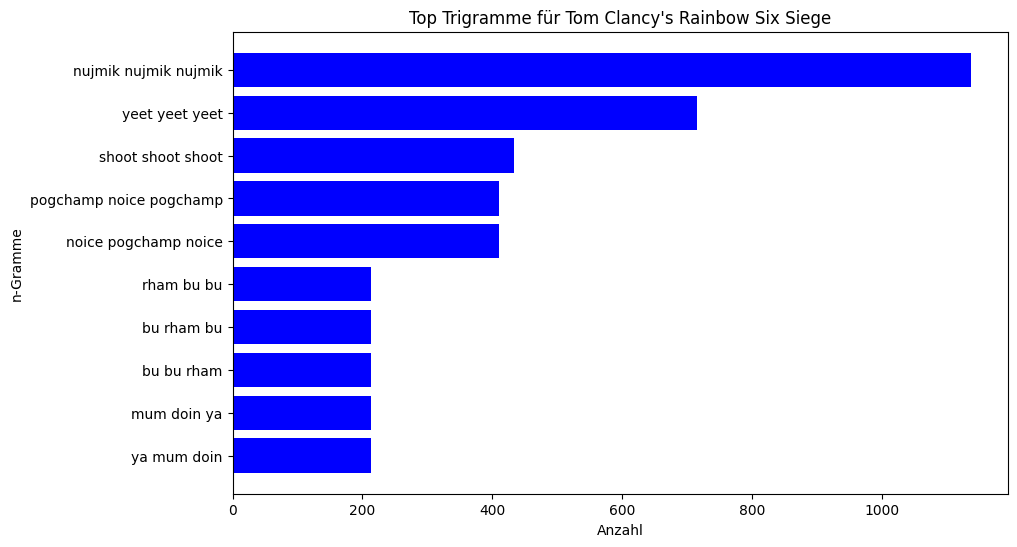

n-Gramme für das Spiel: Grand Theft Auto V


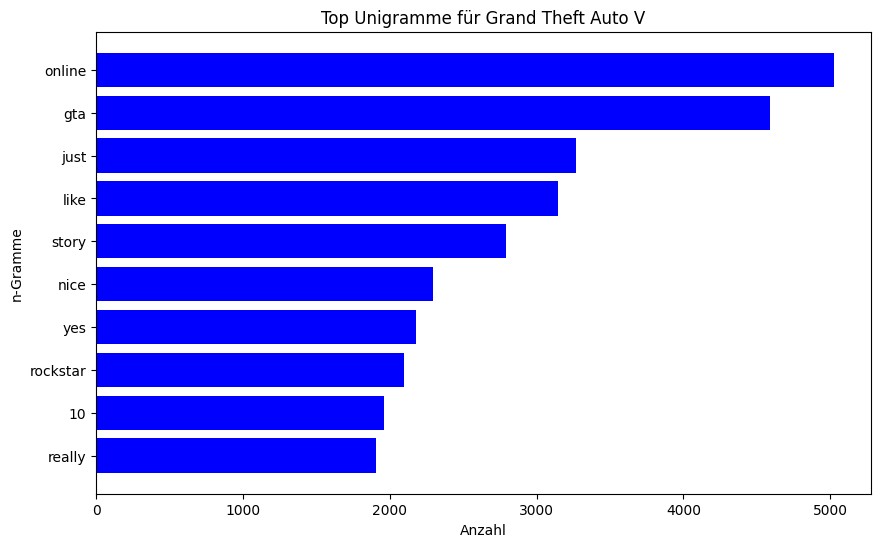

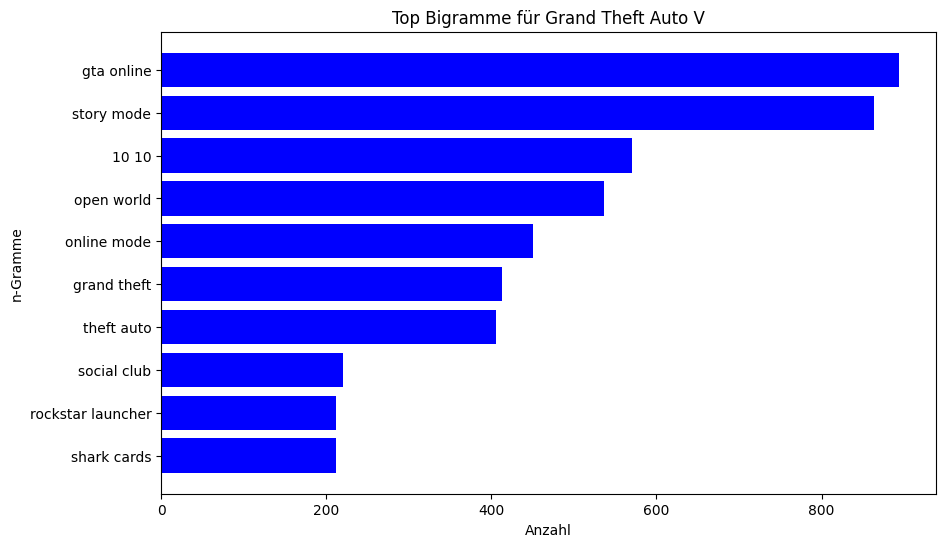

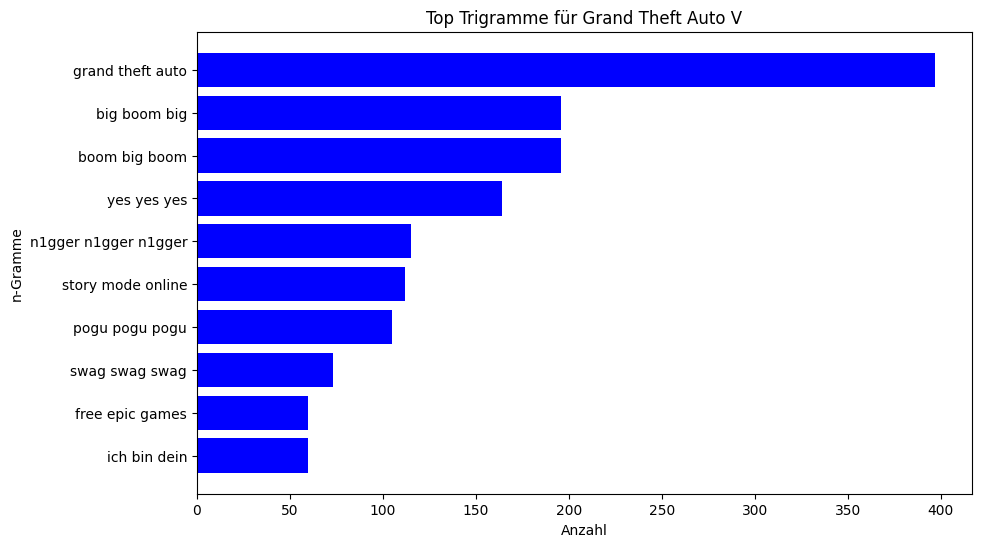

n-Gramme für das Spiel: Garry's Mod


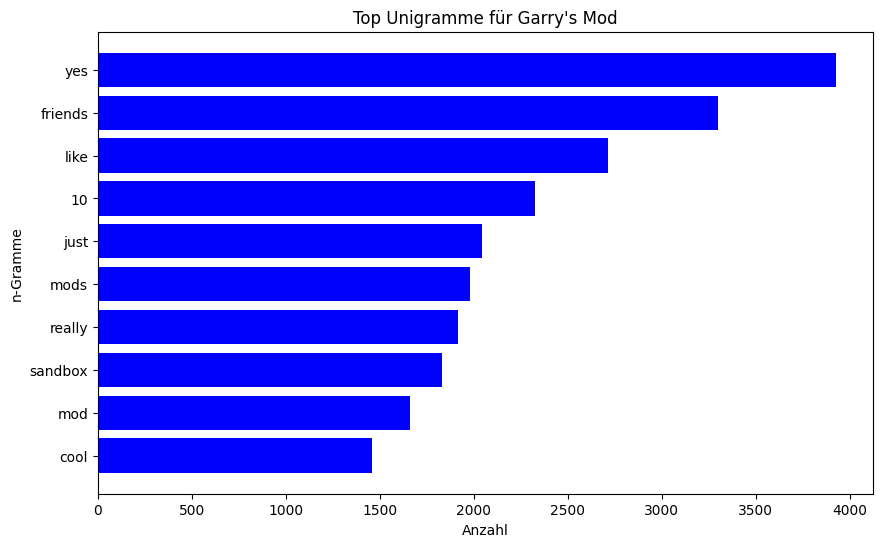

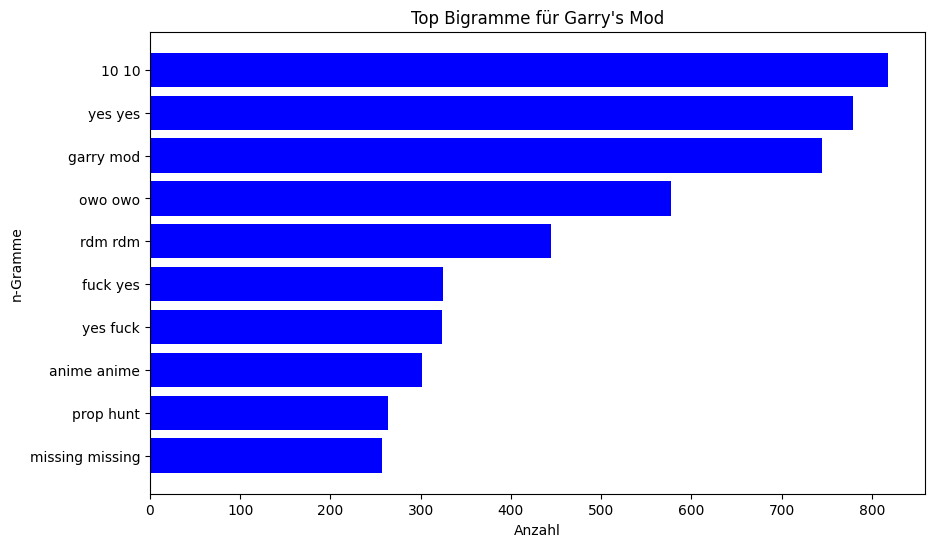

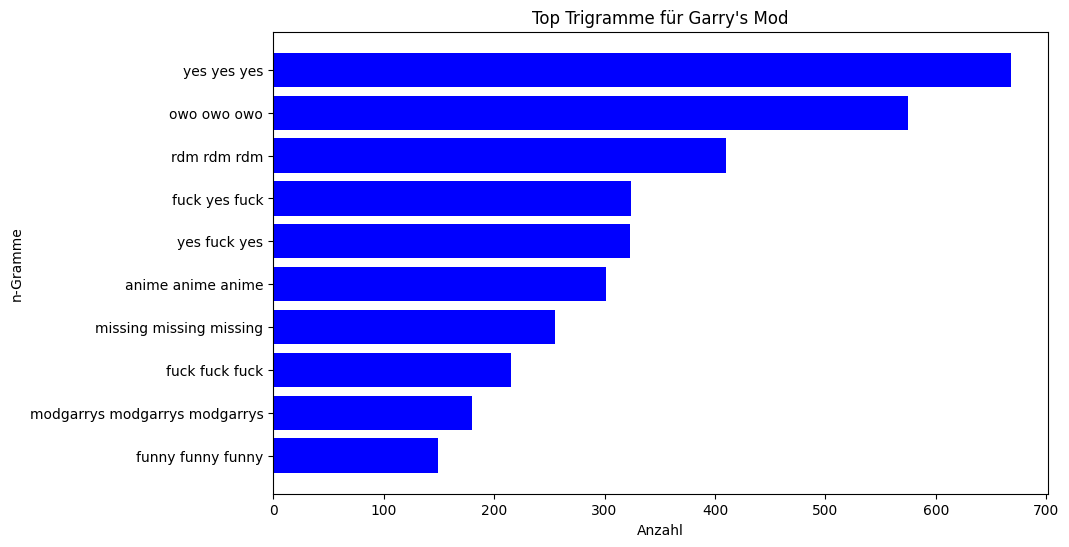

n-Gramme für das Spiel: Hades


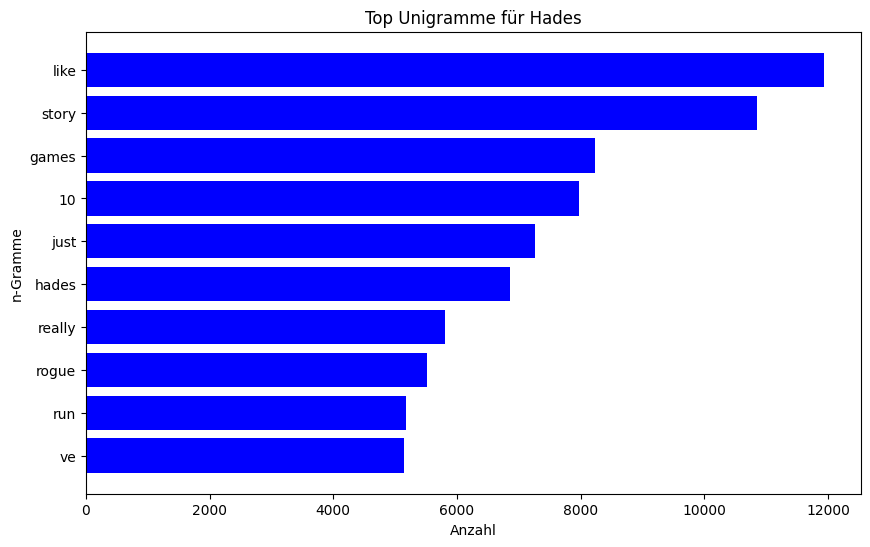

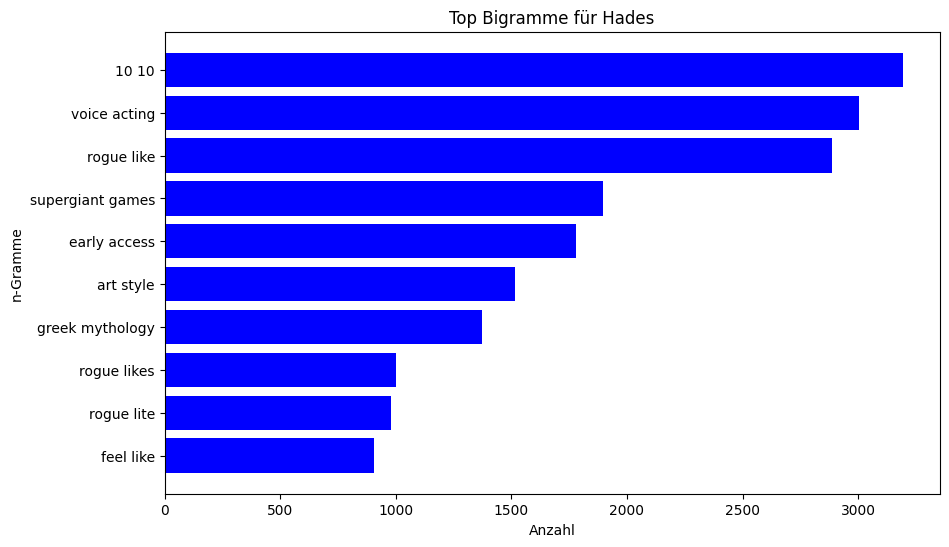

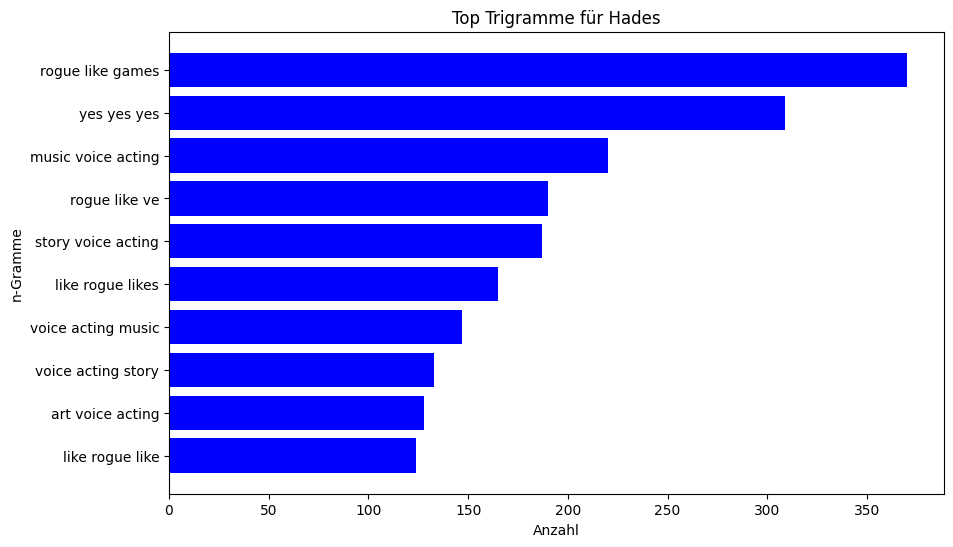

n-Gramme für das Spiel: Stardew Valley


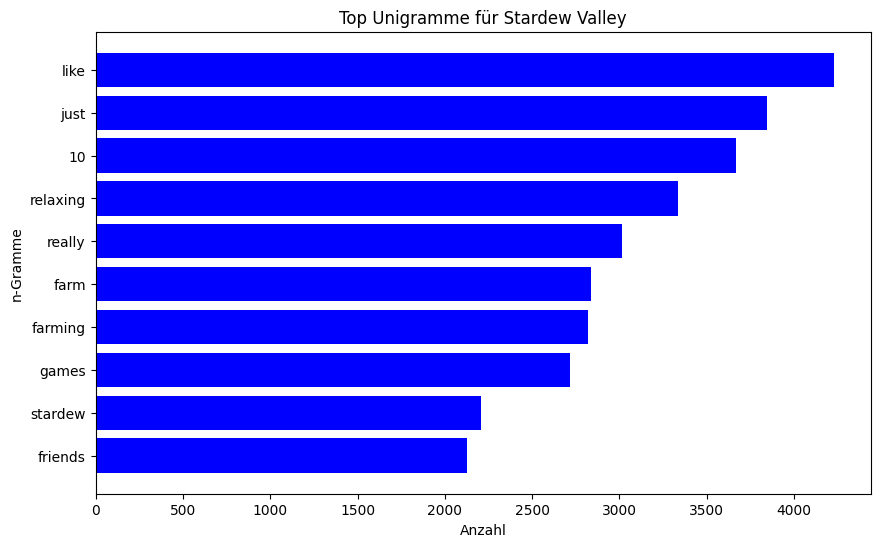

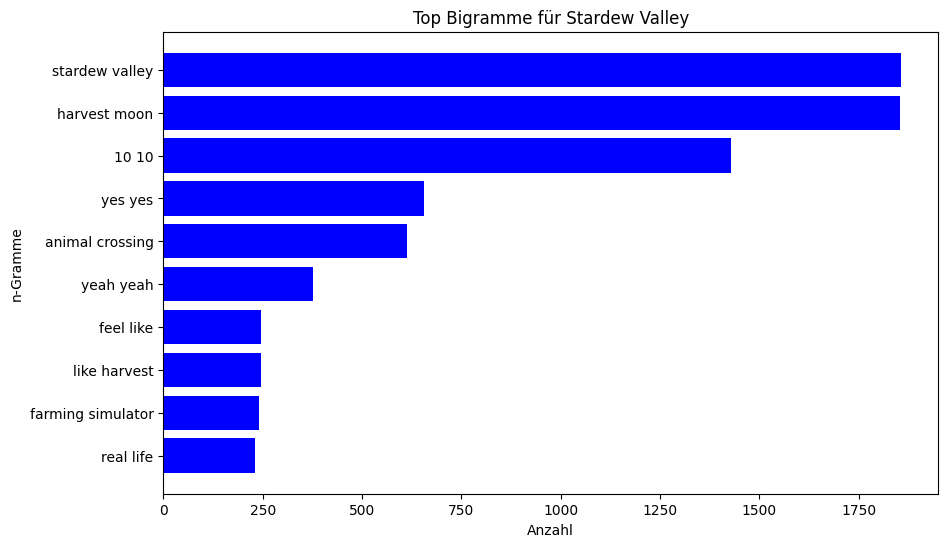

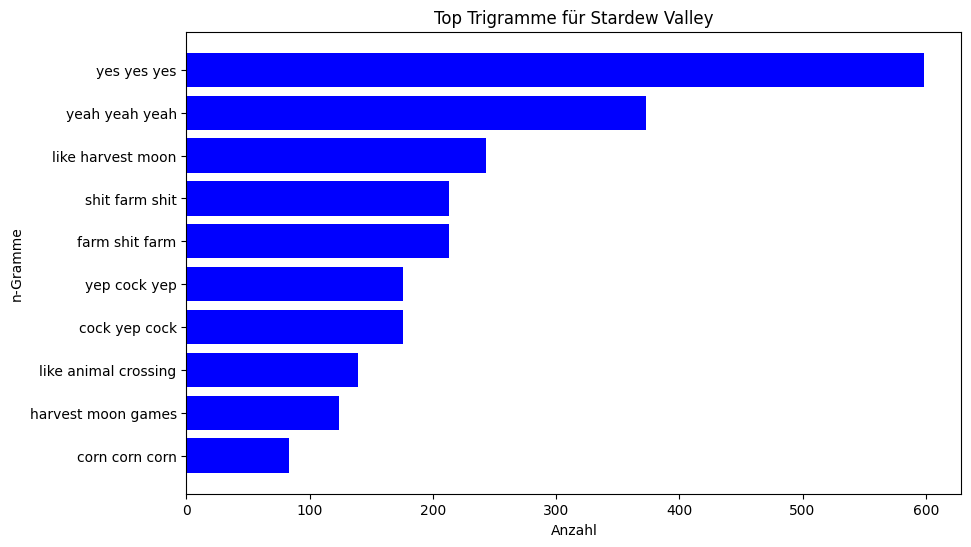

n-Gramme für das Spiel: Half-Life: Alyx


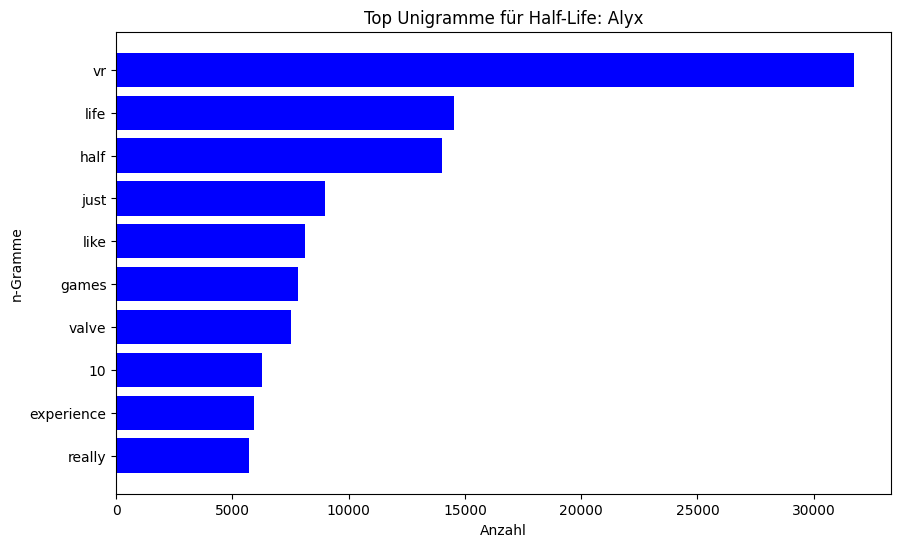

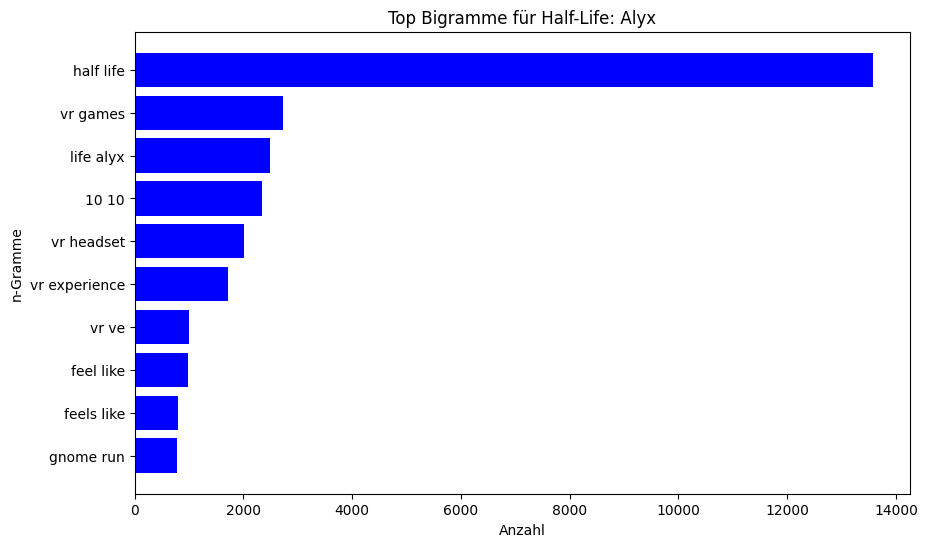

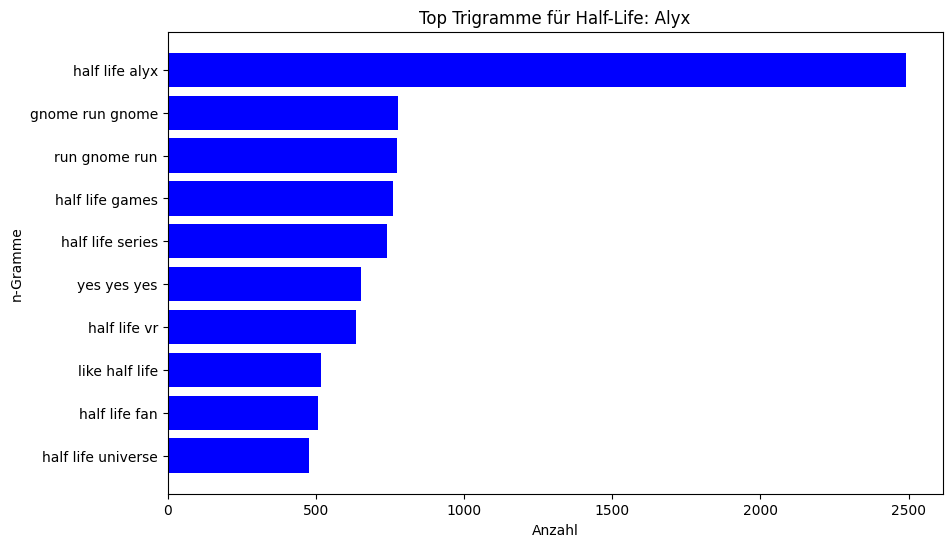

In [32]:
# Zusätzliche Stopwords, um irrelevante Wörter in Spielebewertungen zu entfernen
additional_stopwords = [
    'game', 'gameplay', 'play', 'played', 'playing', 'player', 'level', 'fun', 'time', 'graphics',
    'review', 'recommend', 'recommended', 'enjoy', 'awesome', 'great', 'good', 'bad', 'amazing', 
    'boring', 'love', 'hate', 'steam', 'pc', 'version', 'controller', 'fps', 'must', 'buy', 
    'highly', 'worth', 'money', 'hours', 'best', 'worst', 'bugs', 'patch', 'update', 'loading', 
    'save', 'crash', 'fix'
]

# Funktion zur Erstellung von n-Grammen und deren Visualisierung mit erweiterter Stopword-Liste
def plot_top_ngrams(text_data, ngram_range=(1, 1), top_n=10, title='Top n-Gramme', stopwords=None):
    stopwords = stopwords if stopwords else []
    # Kombiniere die Standard-Stopwords mit den zusätzlichen Stopwords
    stop_words = list(CountVectorizer(stop_words='english').get_stop_words()) + stopwords
    
    vectorizer = CountVectorizer(ngram_range=ngram_range, stop_words=stop_words,max_features=20)
    
    X = vectorizer.fit_transform(text_data)
    word_counts = X.toarray().sum(axis=0)
    ngram_df = pd.DataFrame({'ngram': vectorizer.get_feature_names_out(), 'count': word_counts})
    top_ngrams = ngram_df.sort_values(by='count', ascending=False).head(top_n)
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.barh(top_ngrams['ngram'], top_ngrams['count'], color='blue')
    plt.title(title)
    plt.xlabel('Anzahl')
    plt.ylabel('n-Gramme')
    plt.gca().invert_yaxis()
    plt.show()

# 1. Bestimme die Top 10 Spiele nach Anzahl der Reviews
top_games = df_merged.groupby('app_name').size().reset_index(name='review_count')
top_10_games = top_games.sort_values(by='review_count', ascending=False).head(10)['app_name'].tolist()

# 2. n-Gramme-Analyse für die Top 10 Spiele mit der erweiterten Stopword-Liste
for game_name in top_10_games:
    game_reviews = df_merged[df_merged['app_name'] == game_name]['review'].astype(str)
    
    print(f"n-Gramme für das Spiel: {game_name}")
    
    # Unigramme
    plot_top_ngrams(game_reviews, ngram_range=(1, 1), top_n=10, title=f'Top Unigramme für {game_name}', stopwords=additional_stopwords)
    
    # Bigramme
    plot_top_ngrams(game_reviews, ngram_range=(2, 2), top_n=10, title=f'Top Bigramme für {game_name}', stopwords=additional_stopwords)
    
    # Trigramme
    plot_top_ngrams(game_reviews, ngram_range=(3, 3), top_n=10, title=f'Top Trigramme für {game_name}', stopwords=additional_stopwords)


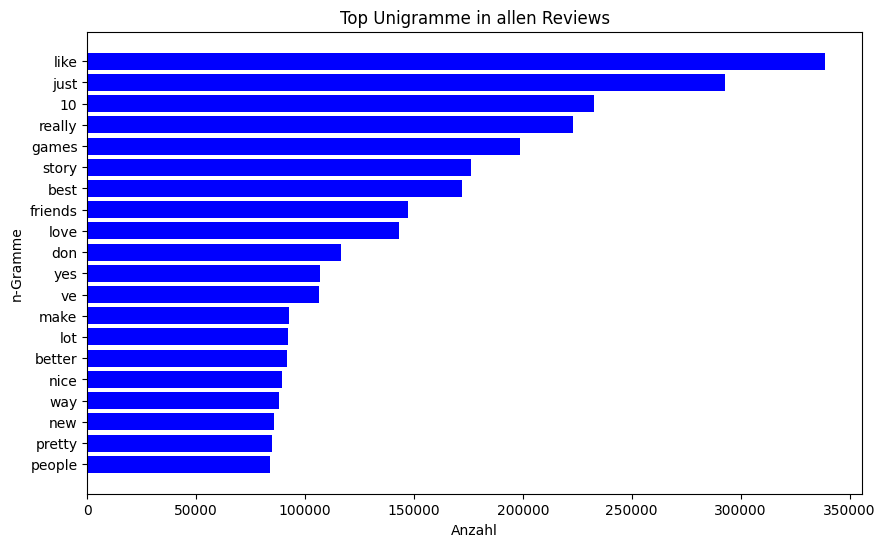

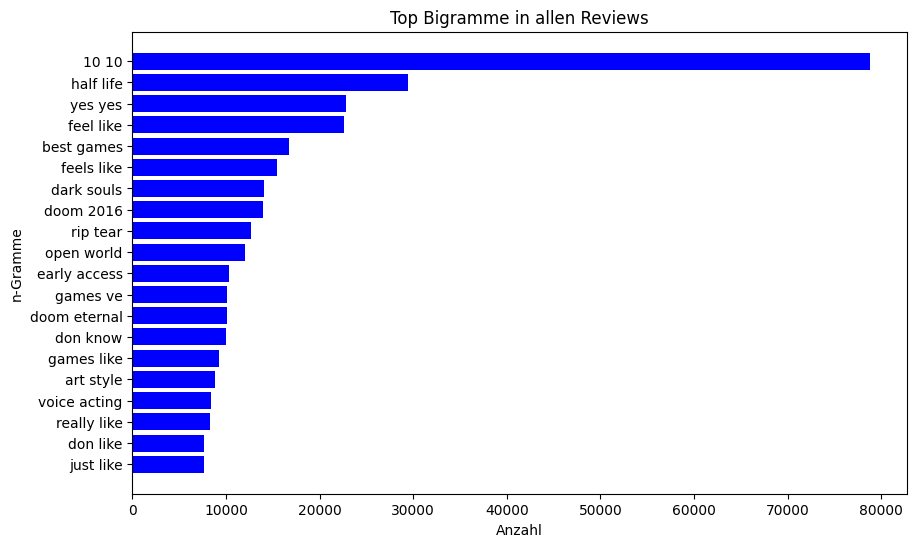

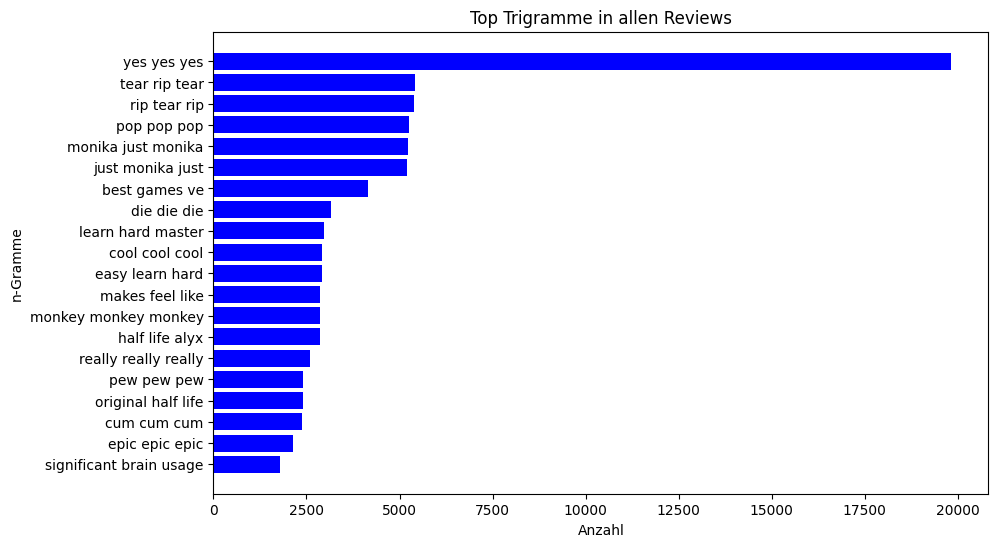

In [33]:
gaming_stopwords = [
    'game', 'gameplay', 'play', 'player', 'played', 'playing', 'level', 'fun', 'graphics', 'sound', 'controls', 
    'fps', 'interface', 'update', 'version', 'mod', 'map', 'character', 'quest', 'mission', 'inventory', 'hud', 
    'difficulty', 'skill', 'achievement', 'boss', 'questline', 'npc', 'enemy', 'ai', 'team', 'match', 'round', 
    'points', 'time', 'hours', 'minute', 'second', 'spent', 'wasting', 'long', 'short', 'session', 'playtime', 
    'save', 'load', 'review', 'recommend', 'recommended', 'not', 'recommended', 'enjoyable', 'amazing', 'awesome', 
    'boring', 'great', 'good', 'bad', 'worth', 'fun', 'must', 'buy', 'refund', 'uninstall', 'buy', 'sale', 'cheap', 
    'expensive', 'bug', 'patch', 'crash', 'freeze', 'lag', 'glitch', 'framerate', 'fps', 'resolution', 'performance', 
    'loading', 'fix', 'update', 'driver', 'steam', 'pc', 'console', 'controller', 'mouse', 'keyboard', 'vr', 'windows', 
    'linux', 'mac', 'move', 'jump', 'run', 'shoot', 'kill', 'aim', 'defend', 'attack', 'dodge', 'collect', 'gather', 
    'craft', 'trade', 'fight', 'win', 'lose', 'respawn', 'build', 'explore', 'climb'
]


import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

# Beispiel-Reviews (Verwende den gesamten df_merged['review'] DataFrame)
reviews = df_merged['review'].astype(str).tolist()

# Funktion zur Erstellung von n-Grammen und deren Visualisierung mit umfassender Gaming-spezifischer Stopword-Liste
def plot_top_ngrams(text_data, ngram_range=(1, 1), top_n=20, title='Top n-Gramme', stopwords=None):
    stopwords = stopwords if stopwords else []
    stop_words = list(CountVectorizer(stop_words='english').get_stop_words()) + stopwords
    
    # Setze max_features, um den Speicherverbrauch zu begrenzen
    vectorizer = CountVectorizer(ngram_range=ngram_range, stop_words=stop_words, max_features=100)
    X = vectorizer.fit_transform(text_data)
    word_counts = X.toarray().sum(axis=0)
    ngram_df = pd.DataFrame({'ngram': vectorizer.get_feature_names_out(), 'count': word_counts})
    top_ngrams = ngram_df.sort_values(by='count', ascending=False).head(top_n)
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.barh(top_ngrams['ngram'], top_ngrams['count'], color='blue')
    plt.title(title)
    plt.xlabel('Anzahl')
    plt.ylabel('n-Gramme')
    plt.gca().invert_yaxis()
    plt.show()

# 1. Unigramme (Einzelne Wörter)
plot_top_ngrams(reviews, ngram_range=(1, 1), top_n=20, title='Top Unigramme in allen Reviews', stopwords=gaming_stopwords)

# 2. Bigramme
plot_top_ngrams(reviews, ngram_range=(2, 2), top_n=20, title='Top Bigramme in allen Reviews', stopwords=gaming_stopwords)

# 3. Trigramme
plot_top_ngrams(reviews, ngram_range=(3, 3), top_n=20, title='Top Trigramme in allen Reviews', stopwords=gaming_stopwords)



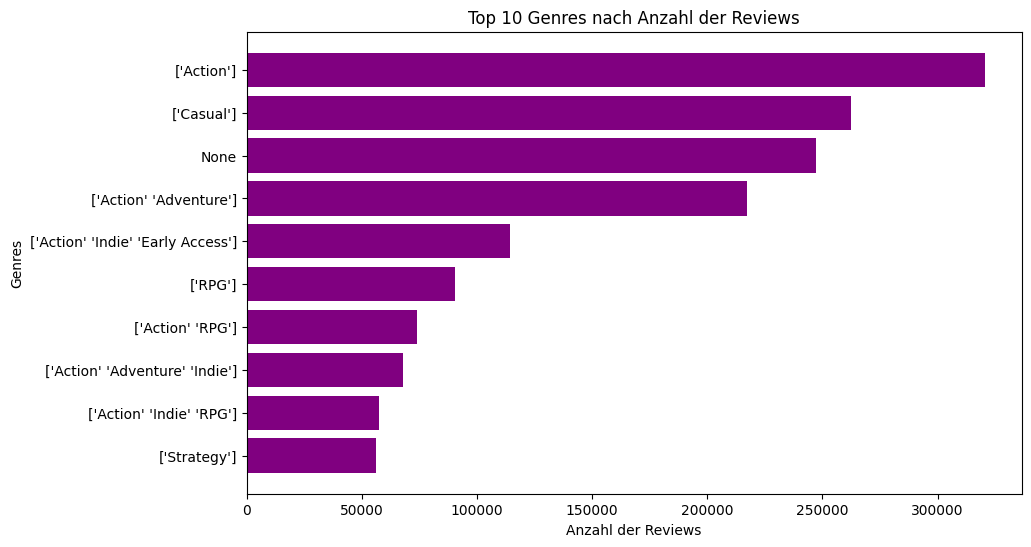

In [25]:
# Sicherstellen, dass 'genres' eine Liste ist und dann in einen String umwandeln
df_merged['genres'] = df_merged['genres'].apply(lambda x: ', '.join(x) if isinstance(x, list) else str(x))

# Gruppieren nach Genre und die Anzahl der Reviews zählen
genre_reviews = df_merged.groupby('genres').size().reset_index(name='review_count')

# Sortiere und zeige die Top 10 Genres nach Anzahl der Reviews
top_genres = genre_reviews.sort_values(by='review_count', ascending=False).head(10)

# Plot: Genre mit den meisten Reviews
plt.figure(figsize=(10, 6))
plt.barh(top_genres['genres'], top_genres['review_count'], color='purple')
plt.title('Top 10 Genres nach Anzahl der Reviews')
plt.xlabel('Anzahl der Reviews')
plt.ylabel('Genres')
plt.gca().invert_yaxis()
plt.show()


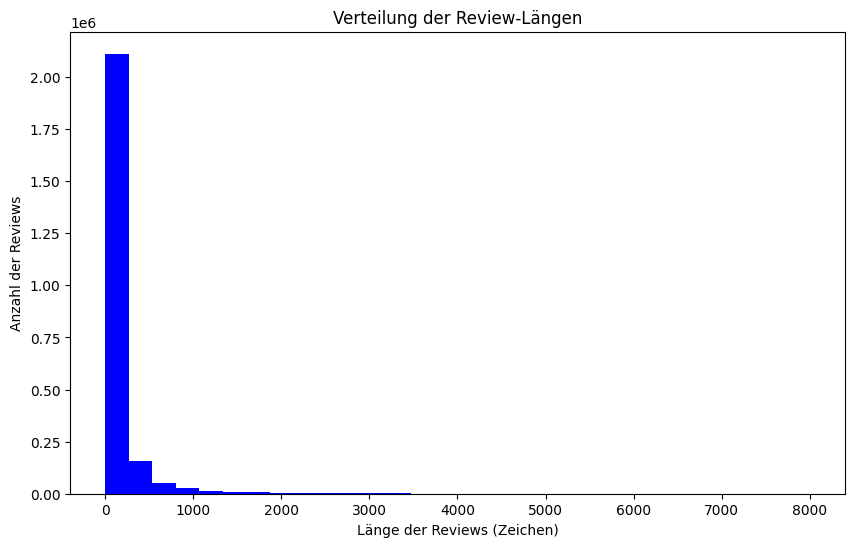

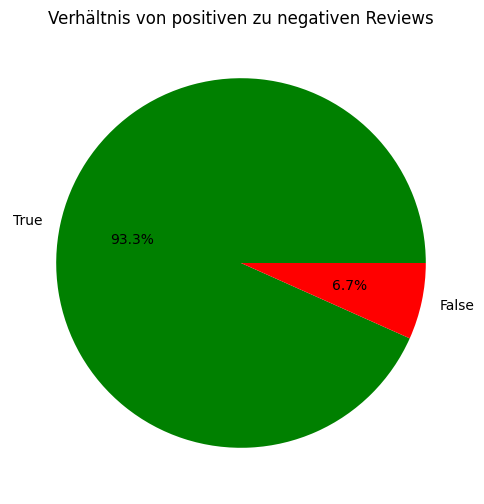

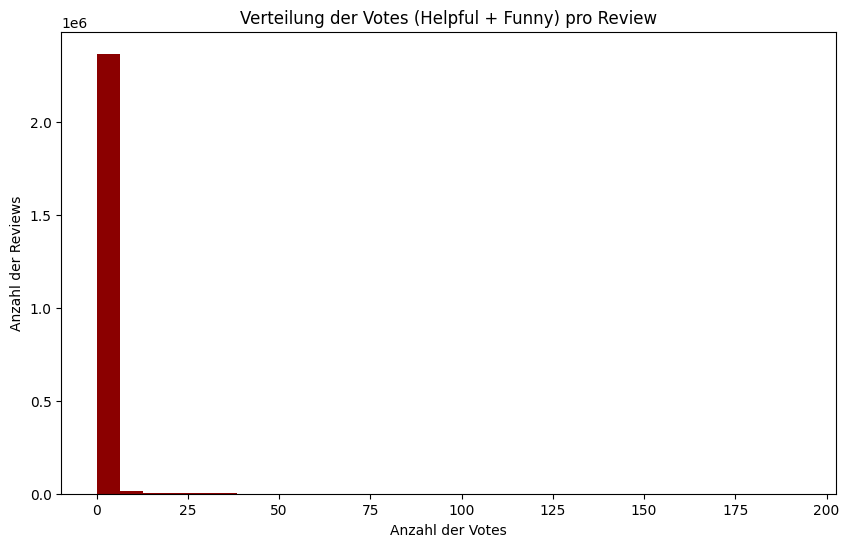

In [26]:
# 1. Verteilung der Review-Längen
df_merged['review_length'] = df_merged['review'].str.len()

# Plot: Verteilung der Review-Längen
plt.figure(figsize=(10, 6))
plt.hist(df_merged['review_length'], bins=30, color='blue')
plt.title('Verteilung der Review-Längen')
plt.xlabel('Länge der Reviews (Zeichen)')
plt.ylabel('Anzahl der Reviews')
plt.show()

# 2. Positiv/Negativ-Verhältnis
review_sentiment = df_merged['recommended'].value_counts(normalize=True).reset_index(name='percentage')
review_sentiment.columns = ['sentiment', 'percentage']

# Plot: Positiv/Negativ-Verhältnis
plt.figure(figsize=(10, 6))
plt.pie(review_sentiment['percentage'], labels=review_sentiment['sentiment'], autopct='%1.1f%%', colors=['green', 'red'])
plt.title('Verhältnis von positiven zu negativen Reviews')
plt.show()

# 3. Votes (Helpful/Funny) pro Review
df_merged['total_votes'] = df_merged['votes_helpful'] + df_merged['votes_funny']

# Plot: Votes pro Review
plt.figure(figsize=(10, 6))
plt.hist(df_merged['total_votes'], bins=30, color='darkred')
plt.title('Verteilung der Votes (Helpful + Funny) pro Review')
plt.xlabel('Anzahl der Votes')
plt.ylabel('Anzahl der Reviews')
plt.show()
